In [30]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from lifelines import WeibullFitter, ExponentialFitter, LogNormalFitter, LogLogisticFitter, LogNormalAFTFitter

# Loading the telco dataset
file_name = 'telco.csv'
df = pd.read_csv(file_name)
df.head()

,ID,region,tenure,age,marital,address,income,ed,retire,gender,voice,internet,forward,custcat,churn
0,1,Zone 2,13,44,Married,9,64,College degree,No,Male,No,No,Yes,Basic service,Yes
1,2,Zone 3,11,33,Married,7,136,Post-undergraduate degree,No,Male,Yes,No,Yes,Total service,Yes
2,3,Zone 3,68,52,Married,24,116,Did not complete high school,No,Female,No,No,No,Plus service,No
3,4,Zone 2,33,33,Unmarried,12,33,High school degree,No,Female,No,No,No,Basic service,Yes
4,5,Zone 2,23,30,Married,9,30,Did not complete high school,No,Male,No,No,Yes,Plus service,No


 This is our telco csv file. It has the region, tenure,age,marital,address,incom,education,retire,gender,voice,internet,forward,custcat,churn and unique ID columns. 

In [31]:
df = df.drop("ID",axis=1)
main_df = df.copy()
dummy_cols = ["churn",'region', 'marital', 'ed', 'retire', 'gender', 'voice', 'internet', 'forward', 'custcat']

df = pd.get_dummies(df,
               columns=dummy_cols,
               prefix=dummy_cols,
               drop_first=True,dtype='int')

df.head()

,tenure,age,address,income,churn_Yes,region_Zone 2,region_Zone 3,marital_Unmarried,ed_Did not complete high school,ed_High school degree,ed_Post-undergraduate degree,ed_Some college,retire_Yes,gender_Male,voice_Yes,internet_Yes,forward_Yes,custcat_E-service,custcat_Plus service,custcat_Total service
0,13,44,9,64,1,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0
1,11,33,7,136,1,0,1,0,0,0,1,0,0,1,1,0,1,0,0,1
2,68,52,24,116,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0
3,33,33,12,33,1,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0
4,23,30,9,30,0,1,0,0,1,0,0,0,0,1,0,0,1,0,1,0


The reason why I dropped the ID columns is that 'ID' column contains unique values for each row and doesn't convey any additional information beyond serving as an identifier. Then my code creates dummy variables for specified categorical columns, and concatenates the original DataFrame with the dummy variables DataFrame.

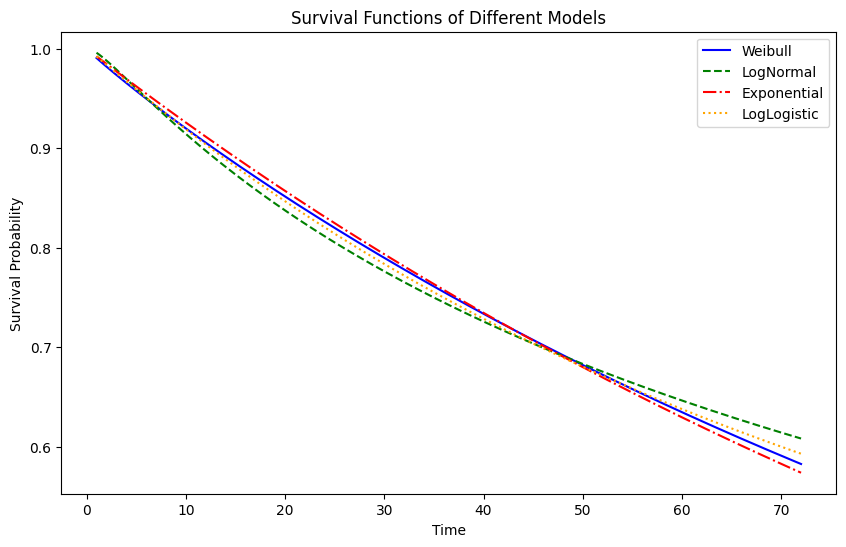

In [32]:
# Define styles for different fitters to make the plot more understandable
styles = {
    "Weibull": {"linestyle": "-", "color": "blue"},
    "LogNormal": {"linestyle": "--", "color": "green"},
    "Exponential": {"linestyle": "-.", "color": "red"},
    "LogLogistic": {"linestyle": ":", "color": "orange"}
}

#mapping my chosen distributions with their funcitons

fitter_dict = {
    "Weibull": WeibullFitter(),
    "LogNormal": LogNormalFitter(),
    "Exponential": ExponentialFitter(),
    "LogLogistic": LogLogisticFitter()
}

#storing the aic,bic values for later on use
aic_values = {}
bic_values = {}

# plot
plt.figure(figsize=(10, 6))

for fitter_name, fitter_instance in fitter_dict.items():
    fitter_instance.fit(durations=df["tenure"], event_observed=df["churn_Yes"])
    fitter_instance.plot_survival_function(ci_show=False, **styles[fitter_name])
    aic_values[fitter_name] = fitter_instance.AIC_
    bic_values[fitter_name] = fitter_instance.BIC_

# Add legend
plt.legend(fitter_dict.keys(), loc="best")

# Add labels and title
plt.xlabel("Time")
plt.ylabel("Survival Probability")
plt.title("Survival Functions of Different Models")
plt.show()


This code defines a dictionary of lifelines fitter instances for various survival models, fits each model to duration data with corresponding event occurrences, plots their survival functions, and collects the AIC and BIC values for each fitted model into separate dictionaries. As we can see from our model, the curves are really close to each other and detecting which one is better is not easy to do by eye. So I will use two identifiers for doing that: AIC and BIC values

In [33]:
# Print AIC and BIC values
print("AIC values:", aic_values)
print("BIC values:", bic_values)

min_aic_fitter = min(aic_values, key=aic_values.get)
min_bic_fitter = min(bic_values, key=bic_values.get)

print(f"Minimum AIC: {aic_values[min_aic_fitter]} (Fitter: {min_aic_fitter})")
print(f"Minimum BIC: {bic_values[min_bic_fitter]} (Fitter: {min_bic_fitter})")

AIC values: {'Weibull': 3216.8611706815464, 'LogNormal': 3209.0351474316735, 'Exponential': 3215.9608134637247, 'LogLogistic': 3214.4154757933375}
BIC values: {'Weibull': 3226.676681239511, 'LogNormal': 3218.850657989638, 'Exponential': 3220.868568742707, 'LogLogistic': 3224.230986351302}
Minimum AIC: 3209.0351474316735 (Fitter: LogNormal)
Minimum BIC: 3218.850657989638 (Fitter: LogNormal)


So the filter with the least aic and bic value is ***LogNormal*** and it will be my choice for now!

In [34]:
best = LogNormalAFTFitter()
best.fit(df, duration_col='tenure', event_col='churn_Yes')
print(best.summary)
best.print_summary()


                                            coef  exp(coef)  se(coef)  \
param  covariate                                                        
mu_    address                          0.042538   1.043456  0.008904   
       age                              0.032670   1.033209  0.007254   
       custcat_E-service                1.066401   2.904907  0.170532   
       custcat_Plus service             0.924929   2.521689  0.215751   
       custcat_Total service            1.198617   3.315528  0.250452   
       ed_Did not complete high school  0.373624   1.452990  0.201587   
       ed_High school degree            0.315938   1.371546  0.163183   
       ed_Post-undergraduate degree    -0.034399   0.966186  0.223172   
       ed_Some college                  0.272306   1.312989  0.165346   
       forward_Yes                     -0.198139   0.820256  0.180037   
       gender_Male                      0.051869   1.053238  0.114287   
       income                           0.001396   

<lifelines.LogNormalAFTFitter: fitted with 1000 total observations, 726 right-censored observations>
             duration col = 'tenure'
                event col = 'churn_Yes'
   number of observations = 1000
number of events observed = 274
           log-likelihood = -1457.01
         time fit was run = 2024-05-01 13:50:30 UTC

---
                                         coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
param  covariate                                                                                                                               
mu_    address                           0.04       1.04       0.01             0.03             0.06                 1.03                 1.06
       age                               0.03       1.03       0.01             0.02             0.05                 1.02                 1.05
       custcat_E-service                 1.07       2.90       0.17             0.73             1.40                 2.08                 4.06
       custcat_Plus service              0.92       2.52       0.22             0.50             1.35                 1.65                 3.85
       custcat_Total service             1.20       3.32       0.25             0.71             1.69                 2.03                 5.42
       ed_Did not complete high school   0.37       1.45       0.20            -0.02             0.77                 0.98                 2.16
       ed_High school degree             0.32       1.37       0.16            -0.00             0.64                 1.00                 1.89
       ed_Post-undergraduate degree     -0.03       0.97       0.22            -0.47             0.40                 0.62                 1.50
       ed_Some college                   0.27       1.31       0.17            -0.05             0.60                 0.95                 1.82
       forward_Yes                      -0.20       0.82       0.18            -0.55             0.15                 0.58                 1.17
       gender_Male                       0.05       1.05       0.11            -0.17             0.28                 0.84                 1.32
       income                            0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
       internet_Yes                     -0.77       0.46       0.14            -1.05            -0.49                 0.35                 0.61
       marital_Unmarried                -0.46       0.63       0.12            -0.68            -0.23                 0.51                 0.80
       region_Zone 2                    -0.10       0.91       0.14            -0.38             0.18                 0.69                 1.20
       region_Zone 3                     0.05       1.05       0.14            -0.23             0.33                 0.80                 1.38
       retire_Yes                        0.02       1.02       0.44            -0.85             0.89                 0.43                 2.44
       voice_Yes                        -0.43       0.65       0.17            -0.76            -0.10                 0.47                 0.90
       Intercept                         2.36      10.61       0.29             1.79             2.94                 5.98                18.84
sigma_ Intercept                         0.28       1.32       0.05             0.19             0.37                 1.20                 1.44

                                         cmp to     z      p   -log2(p)
param  covariate                                                       
mu_    address                             0.00  4.78 <0.005      19.11
       age                                 0.00  4.50 <0.005      17.19
       custcat_E-service                   0.00  6.25 <0.005      31.21
       custcat_Plus service                0.00  4.29 <0.005      15.75
       custcat_Total service               0.00  4.79 <0.005  

Fit the model and see the charcteristics according to that.

In [35]:
subset = ["tenure", "churn_Yes", "address", "age", "custcat_E-service", "custcat_Plus service", "custcat_Total service", "internet_Yes", "marital_Unmarried", "voice_Yes"]
df_subset = df[subset]

best = LogNormalAFTFitter()
best.fit(df_subset, duration_col='tenure', event_col='churn_Yes')
best.print_summary()

<lifelines.LogNormalAFTFitter: fitted with 1000 total observations, 726 right-censored observations>
             duration col = 'tenure'
                event col = 'churn_Yes'
   number of observations = 1000
number of events observed = 274
           log-likelihood = -1462.10
         time fit was run = 2024-05-01 13:50:31 UTC

---
                               coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
param  covariate                                                                                                                     
mu_    address                 0.04       1.04       0.01             0.03             0.06                 1.03                 1.06
       age                     0.04       1.04       0.01             0.02             0.05                 1.02                 1.05
       custcat_E-service       1.03       2.79       0.17             0.69             1.36                 2.00                 3.89
       custcat_Plus service    0.82       2.28       0.17             0.49             1.15                 1.63                 3.17
       custcat_Total service   1.01       2.75       0.21             0.60             1.42                 1.83                 4.15
       internet_Yes           -0.84       0.43       0.14            -1.11            -0.57                 0.33                 0.57
       marital_Unmarried      -0.45       0.64       0.11            -0.67            -0.22                 0.51                 0.80
       voice_Yes              -0.46       0.63       0.17            -0.79            -0.14                 0.45                 0.87
       Intercept               2.53      12.62       0.24             2.06             3.01                 7.84                20.30
sigma_ Intercept               0.28       1.33       0.05             0.19             0.37                 1.21                 1.45

                               cmp to     z      p   -log2(p)
param  covariate                                             
mu_    address                   0.00  4.84 <0.005      19.56
       age                       0.00  5.75 <0.005      26.78
       custcat_E-service         0.00  6.07 <0.005      29.53
       custcat_Plus service      0.00  4.85 <0.005      19.66
       custcat_Total service     0.00  4.83 <0.005      19.52
       internet_Yes              0.00 -6.08 <0.005      29.63
       marital_Unmarried         0.00 -3.91 <0.005      13.39
       voice_Yes                 0.00 -2.78   0.01       7.52
       Intercept                 0.00 10.45 <0.005      82.47
sigma_ Intercept                 0.00  6.15 <0.005      30.27
---
Concordance = 0.78
AIC = 2944.20
log-likelihood ratio test = 280.83 on 8 df
-log2(p) of ll-ratio test = 183.73

It fits a Log-Normal AFT (Accelerated Failure Time) model to the selected subset of data. Then prints the summary of the fitted Log-Normal AFT model, which includes information about coefficients, standard errors, p-values, and other relevant statistics for each predictor variable in the model.

In [36]:
lognormal_model = LogNormalFitter()
lognormal_model.fit(df["tenure"], df["churn_Yes"])
lognormal_summary = lognormal_model.print_summary()
# Additional analysis on lognormal_summary to extract feature importance or coefficients


<lifelines.LogNormalFitter:"LogNormal_estimate", fitted with 1000 total observations, 726 right-censored observations>
   number of observations = 1000
number of events observed = 274
           log-likelihood = -1602.52
               hypothesis = mu_ != 0, sigma_ != 1

---
         coef   se(coef)   coef lower 95%   coef upper 95%
mu_      4.77       0.10             4.57             4.98
sigma_   1.81       0.09             1.64             1.97

         cmp to     z      p   -log2(p)
mu_        0.00 46.06 <0.005        inf
sigma_     1.00  9.37 <0.005      66.94
---
AIC = 3209.04

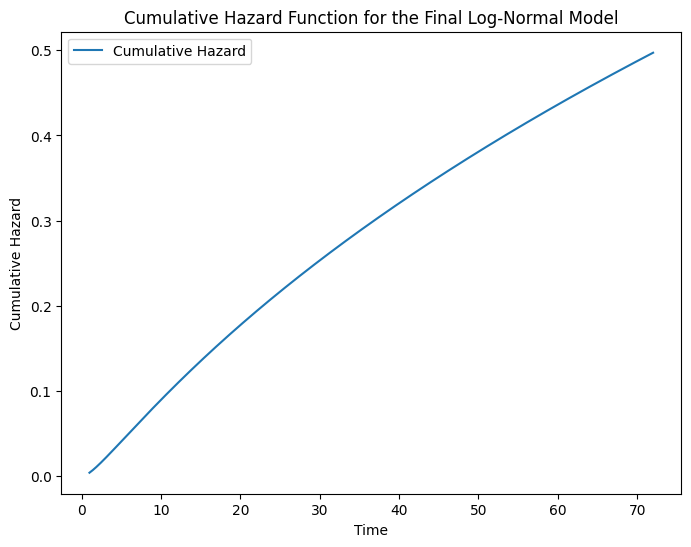

In [37]:
final_model = LogNormalFitter()
final_model.fit(df["tenure"], df["churn_Yes"])

# Obtain cumulative hazard
cumulative_hazard = final_model.cumulative_hazard_

# Plot cumulative hazard function
plt.figure(figsize=(8, 6))
plt.plot(final_model.timeline, cumulative_hazard, label="Cumulative Hazard")
plt.title("Cumulative Hazard Function for the Final Log-Normal Model")
plt.xlabel("Time")
plt.ylabel("Cumulative Hazard")
plt.legend()
plt.show()


This is the hazard function for my final model!  It is a curve

# CLV

In [38]:
# Predict survival function and apply monthly margin
predicted_survival = best.predict_survival_function(df)

monthly_margin = 1000 
predicted_survival = predicted_survival*monthly_margin
drate  = 0.2

predicted_survival = pd.DataFrame({c: [predicted_survival.iloc[r, c] / ((1 + drate)**(r)) for r in range(72)] for c in range(len(predicted_survival.columns))})

In [39]:
df["CLV"] = list(predicted_survival.iloc[71])
main_df["CLV"] = list(predicted_survival.iloc[71])

In [40]:
main_df

,region,tenure,age,marital,address,income,ed,retire,gender,voice,internet,forward,custcat,churn,CLV
0,Zone 2,13,44,Married,9,64,College degree,No,Male,No,No,Yes,Basic service,Yes,0.001383
1,Zone 3,11,33,Married,7,136,Post-undergraduate degree,No,Male,Yes,No,Yes,Total service,Yes,0.001424
2,Zone 3,68,52,Married,24,116,Did not complete high school,No,Female,No,No,No,Plus service,No,0.002236
3,Zone 2,33,33,Unmarried,12,33,High school degree,No,Female,No,No,No,Basic service,Yes,0.000871
4,Zone 2,23,30,Married,9,30,Did not complete high school,No,Male,No,No,Yes,Plus service,No,0.001592
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,Zone 3,10,39,Unmarried,0,27,Some college,No,Female,No,No,No,Basic service,No,0.000681
996,Zone 1,7,34,Unmarried,2,22,Post-undergraduate degree,No,Female,No,No,No,Basic service,No,0.000622
997,Zone 3,67,59,Unmarried,40,944,Post-undergraduate degree,No,Female,Yes,Yes,Yes,Total service,No,0.002043
998,Zone 3,70,49,Unmarried,18,87,High school degree,No,Female,Yes,No,Yes,Plus service,No,0.001703


## CLV is added!

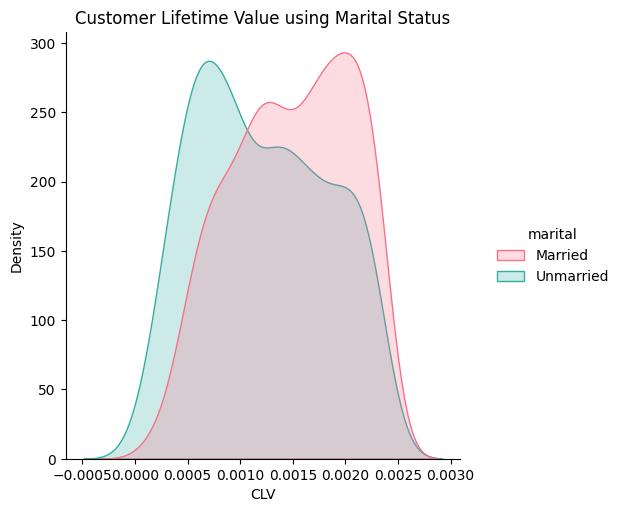

In [41]:
# Create KDE plot for CLV by marital status
martial = sns.displot(data=main_df, x='CLV', kind='kde', hue='marital', fill=True, palette='husl')

# Set title and adjust legend
martial.set(title='Customer Lifetime Value using Marital Status')
plt.plot(title='Marital Status', loc='upper right')
plt.show()


This code creates a KDE plot for CLV (Customer Lifetime Value) by marital status from the given dataframe, using different colors for each marital status group and filling the areas under the curves. Additionally, it sets a title for the plot and adjusts the legend position for better readability.

The difference beetween Married and Unmarried can be seen in the plot above. It seems like the Married people tend to have higher CLV values rather thana the Unmarried ones. This means that they take lower probability of leaving the company. 

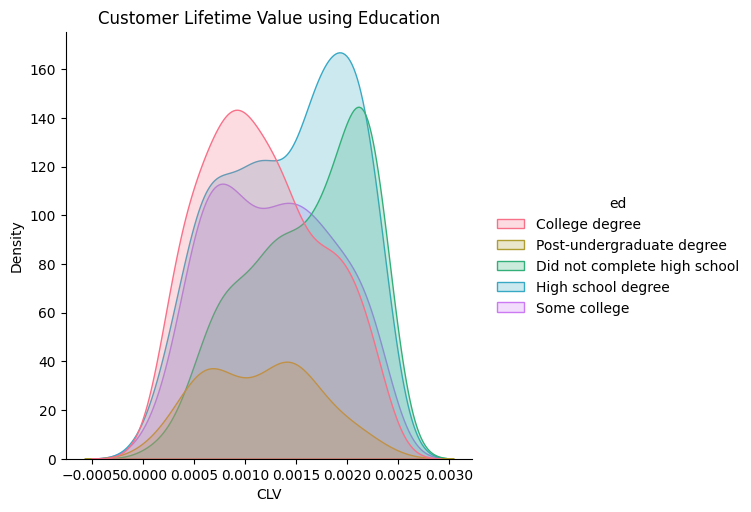

In [42]:
# Create KDE plot for CLV by education
education = sns.displot(data=main_df, x='CLV', kind='kde', hue='ed', fill=True, palette='husl')

# Set title and adjust legend
education.set(title='Customer Lifetime Value using Education')
plt.plot(title='Education', loc='upper right')
plt.show()

We have 5 education levels: College, Post-undergraduate, no high scholl, high school and some college. Almost all of them have different density functions. The highest peak we have is for the high school degree and the least is for the post-undergraduate degree customers. The college and "did not complete" degree sutomers share almost the same peaks and correspondigly almsot the same densities. Yet the ones who have not completed any high scholl have higher clv values and are less probably to leave our company. Keeping the high schoool and not high school completed degress would have been the best decision. 

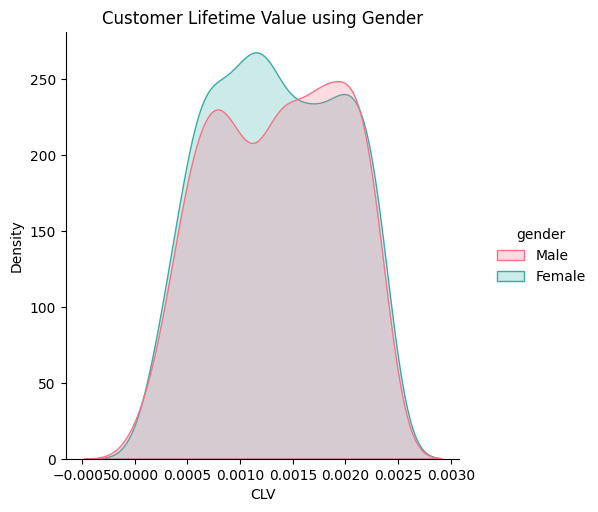

In [43]:
# Create KDE plot for CLV by gender
gender = sns.displot(data=main_df, x='CLV', kind='kde', hue='gender', fill=True, palette='husl')

# Set title and adjust legend
gender.set(title='Customer Lifetime Value using Gender')
plt.plot(title='Gender', loc='upper right')
plt.show()

The plot shows that mostly the gender is not playing a big role. Yet the peal for females is a bit higher than the one of mail customers.

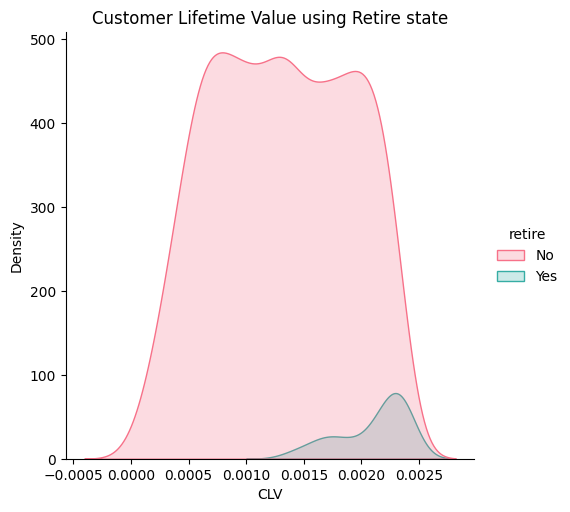

In [44]:
# Create KDE plot for CLV by retire state
retire = sns.displot(data=main_df, x='CLV', kind='kde', hue='retire', fill=True, palette='husl')

# Set title and adjust legend
retire.set(title='Customer Lifetime Value using Retire state')
plt.plot(title='Retire', loc='upper right')
plt.show()

Here we see one of the most definit differences even though the retired customers have higher clvs the density of them is super low compared to not retired customers. The difference of peaks is innormal.

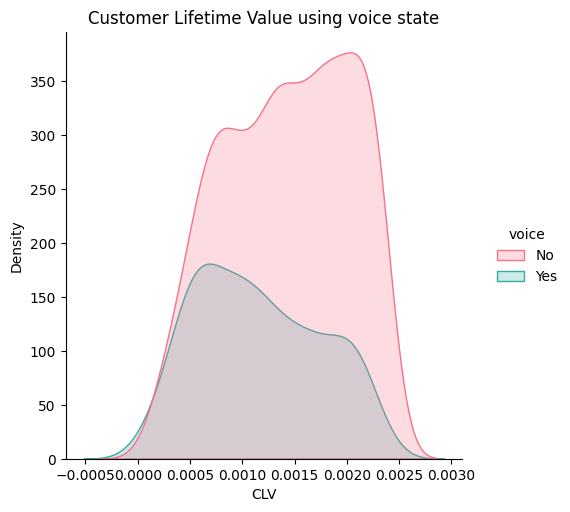

In [45]:
# Create KDE plot for CLV by voice
voice = sns.displot(data=main_df, x='CLV', kind='kde', hue='voice', fill=True, palette='husl')

# Set title and adjust legend
voice.set(title='Customer Lifetime Value using voice state')
plt.plot(title='Voice', loc='upper right')
plt.show()

The voice matters as well! The no voice cutomers have higher density and clv values as well as higher peak rather than the yes voice customers.

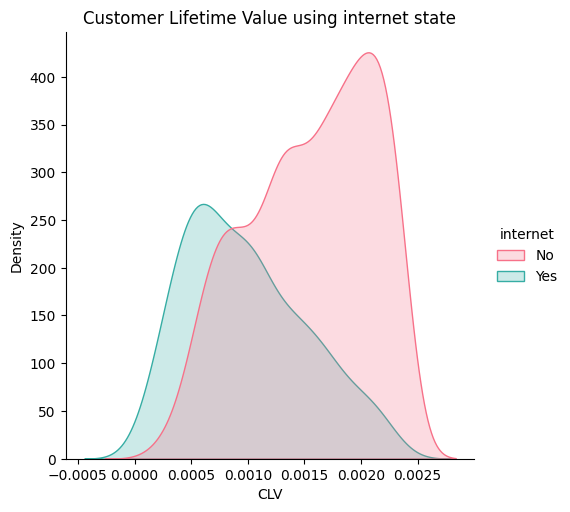

In [46]:
# Create KDE plot for CLV by internet
internet = sns.displot(data=main_df, x='CLV', kind='kde', hue='internet', fill=True, palette='husl')

# Set title and adjust legend
internet.set(title='Customer Lifetime Value using internet state')
plt.plot(title='Internet', loc='upper right')
plt.show()

A really interesting case we have. The no internet cuustomers not only have the highest peak and higher clv values, but also their density is much larger than of yes internet customers. 

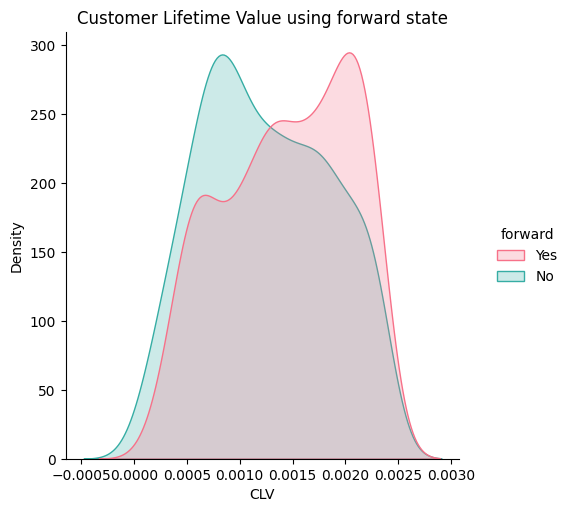

In [47]:
# Create KDE plot for CLV by forward
forward = sns.displot(data=main_df, x='CLV', kind='kde', hue='forward', fill=True, palette='husl')

# Set title and adjust legend
forward.set(title='Customer Lifetime Value using forward state')
plt.plot(title='Forward', loc='upper right')
plt.show()

Here the picture is very similar. Except the values of clv, since the yes forward customers have higher clv values, the peak and densities of both cases are almost the same!

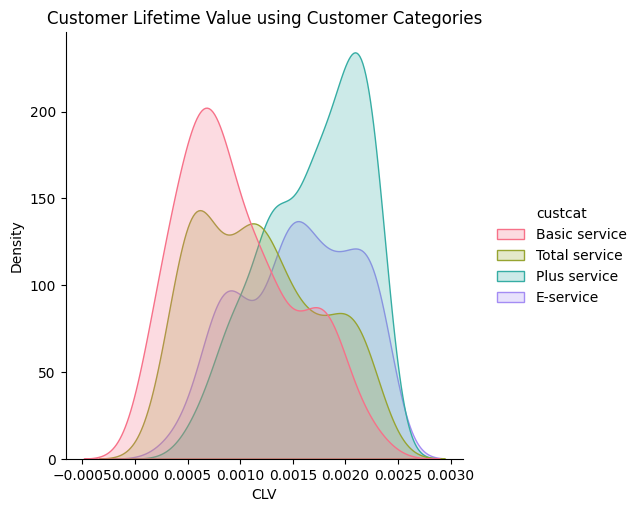

In [48]:
# Create KDE plot for CLV by custcat
custcat = sns.displot(data=main_df, x='CLV', kind='kde', hue='custcat', fill=True, palette='husl')

# Set title and adjust legend
custcat.set(title='Customer Lifetime Value using Customer Categories')
plt.plot(title='Custcat', loc='upper right')
plt.show()

We have 4 custcat categories: Basic, Total, Plus and E-service.The Plus service customers have the highest peak and higher clv values so less likely to leave us. The basic servics customers have the second largest peak and quite big density, yet more with lower clv values. The total and e-service customers share almost the same charachteristics except that e-service customers have higher clv values.

## Annual Retention Budget

In [49]:
# select at-risk subscribers
threshold_clv = 0.001  # Example CLV threshold
at_risk_subscribers = main_df[(main_df['CLV'] < threshold_clv) & (main_df['churn'] == 'Yes')]

# Calculate retention cost per at-risk subscriber
# Assuming we have a fixed retention cost per subscriber
retention_cost_per_subscriber = 100 # I just gave this value

# For simplicity, assuming all subscribers are at risk within a year and calculating how many of them we have
number_of_at_risk_subscribers = len(at_risk_subscribers)

# Step 4: Calculate the annual retention budget
annual_retention_budget = retention_cost_per_subscriber * number_of_at_risk_subscribers
print("Annual Retention Budget:", annual_retention_budget)


Annual Retention Budget: 15200


## Report

**After each plot I have provided the main outputs it gave us!**

Based on our analysis of the churn risk factors, we found several key insights. Interpretation of the coefficients revealed that variables such as customer category, no internet access, no retire, no voice, high school education and being married significantly influence churn risk, with longer tenure and older age associated with lower churn probabilities.

Assuming the dataset represents the population, we estimated the annual retention budget by analyzing CLV, survival probabilities, and identifying at-risk subscribers within a year. By setting a CLV threshold and calculating the retention cost per at-risk subscriber, we determined the budget required to retain customers and mitigate churn risk. Additionally, I would recommend implementing targeted retention strategies tailored to different customer segments, such as personalized offers, loyalty programs, and proactive customer support, to enhance customer satisfaction and loyalty, thereby reducing churn and maximizing long-term profitability.